ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **17Feb21**

# 05. Poisson 1D MOOSE Application
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Problem Statement](#statement)
* [Problem Setup](#setup)
 + [Application](#app)
 + [Diffusion Term Kernel](#diff)
 + [Source Term Kernel](#source)
 + [Compile Application](#compile)
 + [Input File](#input)
 + [Run App](#run)
* [Linear Lagrange FEM Results](#linearfem)
* [Quadratic Lagrange FEM Results](#quadfem)
---

## [Objectives](#toc)<a id="obj"></a>

 + Begin using MOOSE to practice solving ODE's.

## [Strong Form Statement of Poisson 1D Problem](#toc)<a id="statem"></a>

Solve the Poisson model problem. Find $u:[a,b]\in\Reals\rightarrow\Reals$ for $D \ne 0$ such that:

\begin{align*}
 -\bigl(-D\, u'\bigr)'(x) + S &= 0 \quad \forall \quad x\in [a,b], \\
 u(a) &= A, \\
 u(b) &= B.
\end{align*}
   
Solve this problem analytically for constant diffusion coefficient, $D$, and source, $S$. Consider $u(a)$ the 
concentration at the entry point and $u(b)$ the concentration at the exit point.

## [Weak Galerkin Form Statement of Poisson 1D Problem](#toc)<a id="statem"></a>

The Galerkin weak formulation is as follows. Find $u \in H^1\!\bigl([a,b]\bigr)$ so that 

\begin{align*}
 \int\limits_a^b -D\, u'(x)\,v'(x)\,dx + \int\limits_a^b S\,v(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), 
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\in\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty \bigr\}$ and 
$H^1_0\!\bigl([a,b]\bigr) := \bigl\{ v \mid v \in H^1(a,b), v(a) = 0, v(b) =0 \bigr\}$. The latter is a Hilbert space. The function $v$ is called a test function. Because $v$ and $u$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

The two integrals in the weak formulation are the key terms to be computed. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integrals, that is, the kernels. Therefore the kernels needed are:

 1. $-D\, u'(x)\,v'(x)$ ,
 1. $S\,v(x)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.

## [Problem Setup](#toc)<a id="setup"></a>

We need to create a MOOSE *application* with two MOOSE *kernels* and an *input* file. The ODE problem has a diffusion and a source term. Therefore a good way to proceed is to have two MOOSE kernels coded in C++ programming language.

#### [MOOSE App Creation](#toc)<a id="app"></a>

1. Make sure `MOOSE` has been installed and most tests passed successfully.
1. `cd ~/moose`
1. `cd ..`
1. `./moose/scripts/stork.sh Engy5310P1`
1. Disregard the `github` setup
1. `cd engy5310p1`
1. `make`
1. `./run_tests`
1. `cp test/tests/kernels/simple_diffusion/simple_diffusion.i input.i`
1. Cleanup: `rm -rf test/, unit/, doc/, scripts/, and run_tests`
1. Edit `src/main.C`
 - Replace `Engy5310P1TestApp` with `Engy5310P1App`
1. `make clean`
1. `make`
1. Test run 
 + `./engy5310p1-opt -i input.i`
1. Use [`VisIt`](https://wci.llnl.gov/simulation/computer-codes/visit) or `Paraview` to visualize `test_out.e`

#### [Add a Diffusion Term Kernel](#toc)<a id="diff"></a>
1. `cd include`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `DiffusionTerm.h` class interface.
 + Use the `EquationTerm.h` template as follows:
 + `cp *path-to*/moose-app-templates/EquationTerm.h .`
 + `mv EquationTerm.h DiffusionTerm.h`
1. `cd ../..`
1. `cd src`
1. `mkdir kernels`
1. `cd kernels`
1. Create a `DiffusionTerm.C` class implementation.
 + Use the `EquationTerm.C` template as follows.
 + `cp *path-to*/moose-app-templates/EquationTerm.C .`
 + `mv EquationTerm.C DiffusionTerm.C`

#### [Add a Source Term Kernel](#toc)<a id="source"></a>
1. `cd include`
1. `mkdir kernel`
1. Create a `SourceTerm.h` class interface.
  + Use the `EquationTerm.h` template.
1. Create a `SourceTerm.C` class implementation.
  + Use the `EquationTerm.h` template.

#### [Compile Application](#toc)<a id="compile"></a>

1. `cd ../..`
1. `pwd`
  + `.../engy5310p1`
1. `make`

+ Linking Library `.../engy5310p1/lib/libengy5310p1-opt.la...`

+ Linking Executable `.../engy5310p1/engy5310p1-opt...`

#### [Input File](#toc)<a id="input"></a>

Any line in the "blocked MOOSE input format information below" without a comment (any text to the righ of *#*) refers to a MOOSE framework parameter. Consult the documentation for further info on these parameters. All user-app parameters for this problem are described with comments below. Use the content below to create an `input.i` input file. That is, using a text editor copy and paste the content below into a new file and save it as a `text` file format with name `input.i`.
```
[Mesh]
 [1d]                                # any lower case name; this is our 1D block
  type = GeneratedMeshGenerator  
  dim = 1 
  xmin = 0 
  xmax = 25
  nx = 1 
 []
[]

[Variables]
 [u]                                 # our unknown variable to be related to below
  order = first
  family = lagrange
 []
[]

[Kernels]
 [diffusion-term]                    # our diffusion term kernel implemented in the app
  type = DiffusionTerm               # our name for the diffusion kernel C++ class
  variable = u                       # our unknown variable from the [Variables] block
  diffCoeff = 1.00000e-01            # our defined diffusion coefficient C++ variable
 []
 [source-term]                       # our source term kernel implemented in the app
  type = SourceTerm                  # our name for the source kernel C++ class
  variable = u                       # our unknown variable from the [Variables] block
  sourceS = 1.0000e-03               # our defined source constant C++ variable
 []
[]

[BCs]
 [entry]                             # our name for the left side of the boundary of the domain
  type = DirichletBC
  variable = u                       # our unknown variable from the [Variables] block
  boundary = left
  value = 3.00000e+00
 []
 [exit]                              # our name for the left side of the boundary of the domain
  type = DirichletBC
  variable = u                       # our unknown variable from the [Variables] block
  boundary = right
  value = 0.0
 []
[]

[Executioner]
 type = Steady
 solve_type = 'PJFNK'
 petsc_options_iname = '-pc_type -pc_hypre_type'
 petsc_options_value = 'hypre boomeramg'
[]

[VectorPostprocessors]
 [u]                                 # our unknown variable
  type = LineValueSampler
  execute_on = 'timestep_end final'
  variable = 'u'                     # our unknown variable from the [Variables] block
  start_point = '0 0 0'
  end_point = '25 0 0'
  num_points = 7
  sort_by = id
 []
[]

[Outputs]
 [csv]                              # our choice for data output: tabular
  type = CSV
  file_base = 'output'
  execute_on = 'final'
 []
[]

```
Save the input file in the `.../engy5310p1/` directory

#### [Run Application](#toc)<a id="run"></a>

1. In the `engy5310p1/` directory run the application with the Linux shell command:
 + `./engy5310p1-opt -i input.i`

## [Linear Lagrange FEM](#toc)<a id="linearfem"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cc^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: First Order Lagrangian
> + num. of finite elements: 3

In [1]:
'''FEM Solution'''

x_a = 0
x_b = 25
u_a = 3
u_b = 0

diff_coeff = 0.1
source_s = 1e-3

n_felem = 3
order = 'first'
n_plot_pts = 2*n_felem + 1

from engy_5310.toolkit import run_engy5310_p1

run_engy5310_p1(x_a, x_b, u_a, u_b, diff_coeff, source_s, n_felem, order, n_plot_pts)

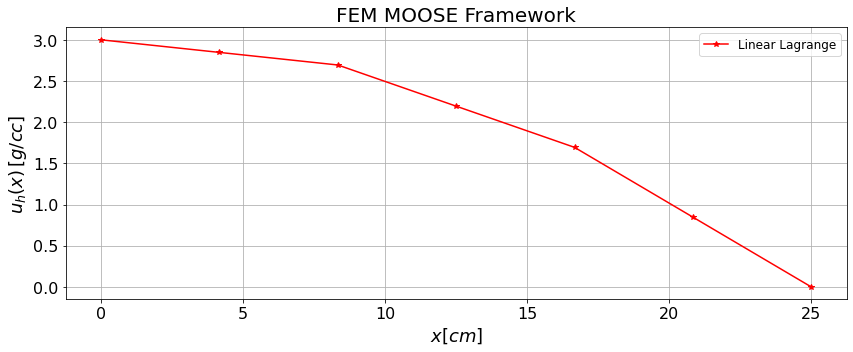

In [2]:
'''Show FEM Solution'''

import pandas as pd

df = pd.read_csv('engy5310p1/output_u_0002.csv')
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(14, 5))
plt.plot(df['x'], df['u'],'r*-',label='Linear Lagrange')
plt.title('FEM MOOSE Framework', fontsize=20)
plt.ylabel(r'$u_h(x)\,[g/cc]$', fontsize=18)
plt.xlabel(r'$x [cm]$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

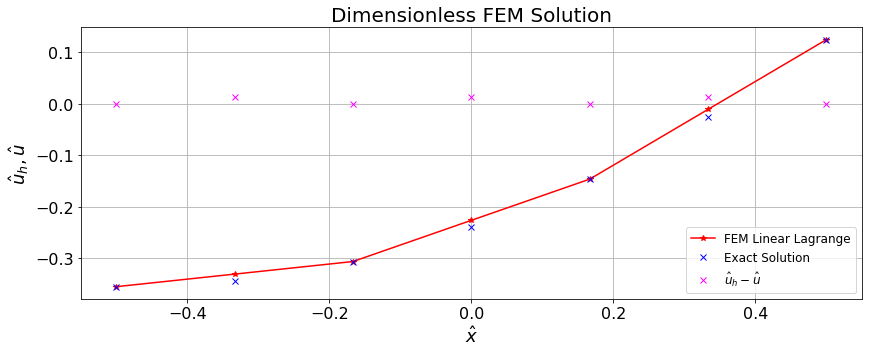

In [3]:
'''Error'''

from engy_5310.toolkit import engy5310_p1_exact_solution

u_hat = engy5310_p1_exact_solution(x_a, x_b, u_a, u_b, diff_coeff, source_s)

L = df['x'].max() - df['x'].min()
x_hat = (df['x'] - df['x'].min())/L - 0.5

C = - source_s / diff_coeff
uh_hat = df['u']/C/L**2 + 1/8

plt.figure(1, figsize=(14, 5))
plt.plot(x_hat, uh_hat,'r-*',label='FEM Linear Lagrange')
plt.plot(x_hat, u_hat.values(x_hat),'bx',label='Exact Solution')
plt.plot(x_hat, uh_hat-u_hat.values(x_hat),'x',color='magenta',label=r'$\hat{u}_h-\hat{u}$')
plt.title('Dimensionless FEM Solution', fontsize=20)
plt.ylabel(r'$\hat{u}_h, \hat{u}$', fontsize=18)
plt.xlabel(r'$\hat{x}$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()



## [Quadratic Lagrange FEM](#toc)<a id="quadfem"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + A = 3 g/cc
> + B = 0 g/cc
> + D = 0.1 cc^2/s
> + S = 1e-3 g/cc-s

FEM parameters:

> + Basis Functions: Second Order Lagrangian
> + num. of finite elements: 1

In [8]:
'''FEM Solution'''

x_a = 0
x_b = 25
u_a = 3
u_b = 0

diff_coeff = 0.1
source_s = 1e-3

n_felem = 1
order = 'second'
#n_plot_pts = 2*n_felem + 1
n_plot_pts = 10

from engy_5310.toolkit import run_engy5310_p1

run_engy5310_p1(x_a, x_b, u_a, u_b, diff_coeff, source_s, n_felem, order, n_plot_pts)

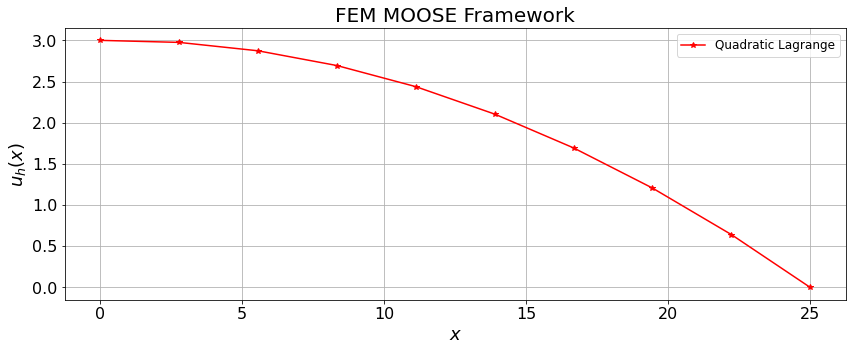

In [9]:
'''Show FEM Solution'''

import pandas as pd

df = pd.read_csv('engy5310p1/output_u_0002.csv')
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(14, 5))
plt.plot(df['x'], df['u'],'r*-',label='Quadratic Lagrange')
plt.title('FEM MOOSE Framework', fontsize=20)
plt.ylabel(r'$u_h(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

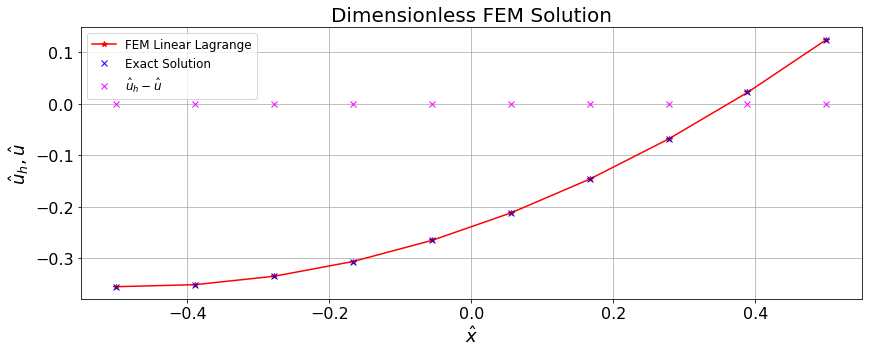

In [10]:
'''Error'''

from engy_5310.toolkit import engy5310_p1_exact_solution

u_hat = engy5310_p1_exact_solution(x_a, x_b, u_a, u_b, diff_coeff, source_s)

L = df['x'].max() - df['x'].min()
x_hat = (df['x'] - df['x'].min())/L - 0.5

c = - source_s / diff_coeff
uh_hat = df['u']/c/L**2 + 1/8

plt.figure(1, figsize=(14, 5))
plt.plot(x_hat, uh_hat,'r-*',label='FEM Linear Lagrange')
plt.plot(x_hat, u_hat.values(x_hat),'bx',label='Exact Solution')
plt.plot(x_hat, uh_hat-u_hat.values(x_hat),'x',color='magenta',label=r'$\hat{u}_h-\hat{u}$')
plt.title('Dimensionless FEM Solution', fontsize=20)
plt.ylabel(r'$\hat{u}_h, \hat{u}$', fontsize=18)
plt.xlabel(r'$\hat{x}$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

